# HousePrices

I cobbled together a data preprocessing module. Let's now import it and play around with it a little bit.

In [1]:
import preprocessing as pre
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer

In [3]:
import os
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

In [4]:
sns.set_theme(style="whitegrid", palette="tab10")

Read in the data:

In [5]:
path   = Path("/Users/rmyazdi/Documents/kaggle/house_prices/data")
train  = pre.load_data(path, "train")
test   = pre.load_data(path, "test")
train  = pre.add_features(train)
test   = pre.add_features(test)
train  = train.set_index(train.Id).drop("Id", axis=1)
test   = test.set_index(test.Id).drop("Id", axis=1)

TypeError: Cannot setitem on a Categorical with a new category (None), set the categories first

There are a lot of features in this data set. I really don't think all are going to be significantly important in predicting the price. Separate Features from Labels:

In [6]:
X_train = train.drop("SalePrice", axis=1)
Y_train = train.SalePrice

In [7]:
X_train[X_train.isnull().any(axis=1)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,n_baths,area_with_bsmt,Age,Renovate
Id,,,,,,,,,,,,,,,,,,,,,


In [9]:
X_train.convert_dtypes()
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 83 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   MSSubClass        1460 non-null   category
 1   MSZoning          1460 non-null   category
 2   LotFrontage       1460 non-null   float64 
 3   LotArea           1460 non-null   int64   
 4   Street            1460 non-null   category
 5   Alley             1460 non-null   category
 6   LotShape          1460 non-null   category
 7   LandContour       1460 non-null   category
 8   Utilities         1460 non-null   category
 9   LotConfig         1460 non-null   category
 10  LandSlope         1460 non-null   category
 11  Neighborhood      1460 non-null   category
 12  Condition1        1460 non-null   category
 13  Condition2        1460 non-null   category
 14  BldgType          1460 non-null   category
 15  HouseStyle        1460 non-null   category
 16  OverallQual       1460 non-nu

In [15]:
X_train.MSSubClass.astype("str")

Id
1       60
2       20
3       60
4       70
5       60
        ..
1456    60
1457    20
1458    70
1459    20
1460    20
Name: MSSubClass, Length: 1460, dtype: object

Get column names separated into nominal, ordinal and non-categorical, real-value features:

In [16]:
nominal_features = pre.nominals
ordinal_features = pre.ordered_categories
ord_features_names = list(ordinal_features.keys())
numeric_real_features = [name for name in X_train.select_dtypes(np.float64)]

Now construct a _ColumnTransformer_ object to deal with the preprocessing of the entire data set. The transformer should take a dataframe and make it ready for usage in the various models that come in later.

In [17]:
ctr = ColumnTransformer([("numberTrans", StandardScaler(), numeric_real_features),
                        ("ordinalTrans", OrdinalEncoder(), ord_features_names),
                        ("nominalTrans", OneHotEncoder(sparse_output=False).set_output(transform="pandas"), nominal_features)])
ctr.set_output(transform="pandas")

ColumnTransformer(transformers=[('numberTrans', StandardScaler(),
                                 ['LotFrontage', 'MasVnrArea', 'GarageYrBlt',
                                  'n_baths']),
                                ('ordinalTrans', OrdinalEncoder(),
                                 ['OverallQual', 'OverallCond', 'ExterCond',
                                  'ExterQual', 'BsmtQual', 'BsmtCond',
                                  'BsmtExposure', 'HeatingQC', 'KitchenQual',
                                  'FireplaceQu', 'GarageQual', 'GarageCond',
                                  'PoolQC', 'BsmtFinType1', 'BsmtFinType2',
                                  'Gar...
                                ('nominalTrans',
                                 OneHotEncoder(sparse_output=False),
                                 ['MSSubClass', 'MSZoning', 'Street', 'Alley',
                                  'Utilities', 'LotConfig', 'Neighborhood',
                                  'Condition1', 'Condition2', 'BldgType',
                                  'HouseStyle', 'RoofStyle', 'RoofMatl',
                                  'Exterior1st', 'Exterior2nd', 'MasVnrType',
                                  'Foundation', 'Heating', 'Electrical',
                                  'GarageType', 'MiscFeature', 'SaleType',
                                  'SaleCondition', 'CentralAir'])])

In [18]:
train_tr = ctr.fit_transform(X_train)

TypeError: Encoders require their input argument must be uniformly strings or numbers. Got ['int', 'str']

In [11]:
train_tr.shape

NameError: name 'train_tr' is not defined

In [20]:
train_tr[train_tr.isna()]

NameError: name 'train_tr' is not defined

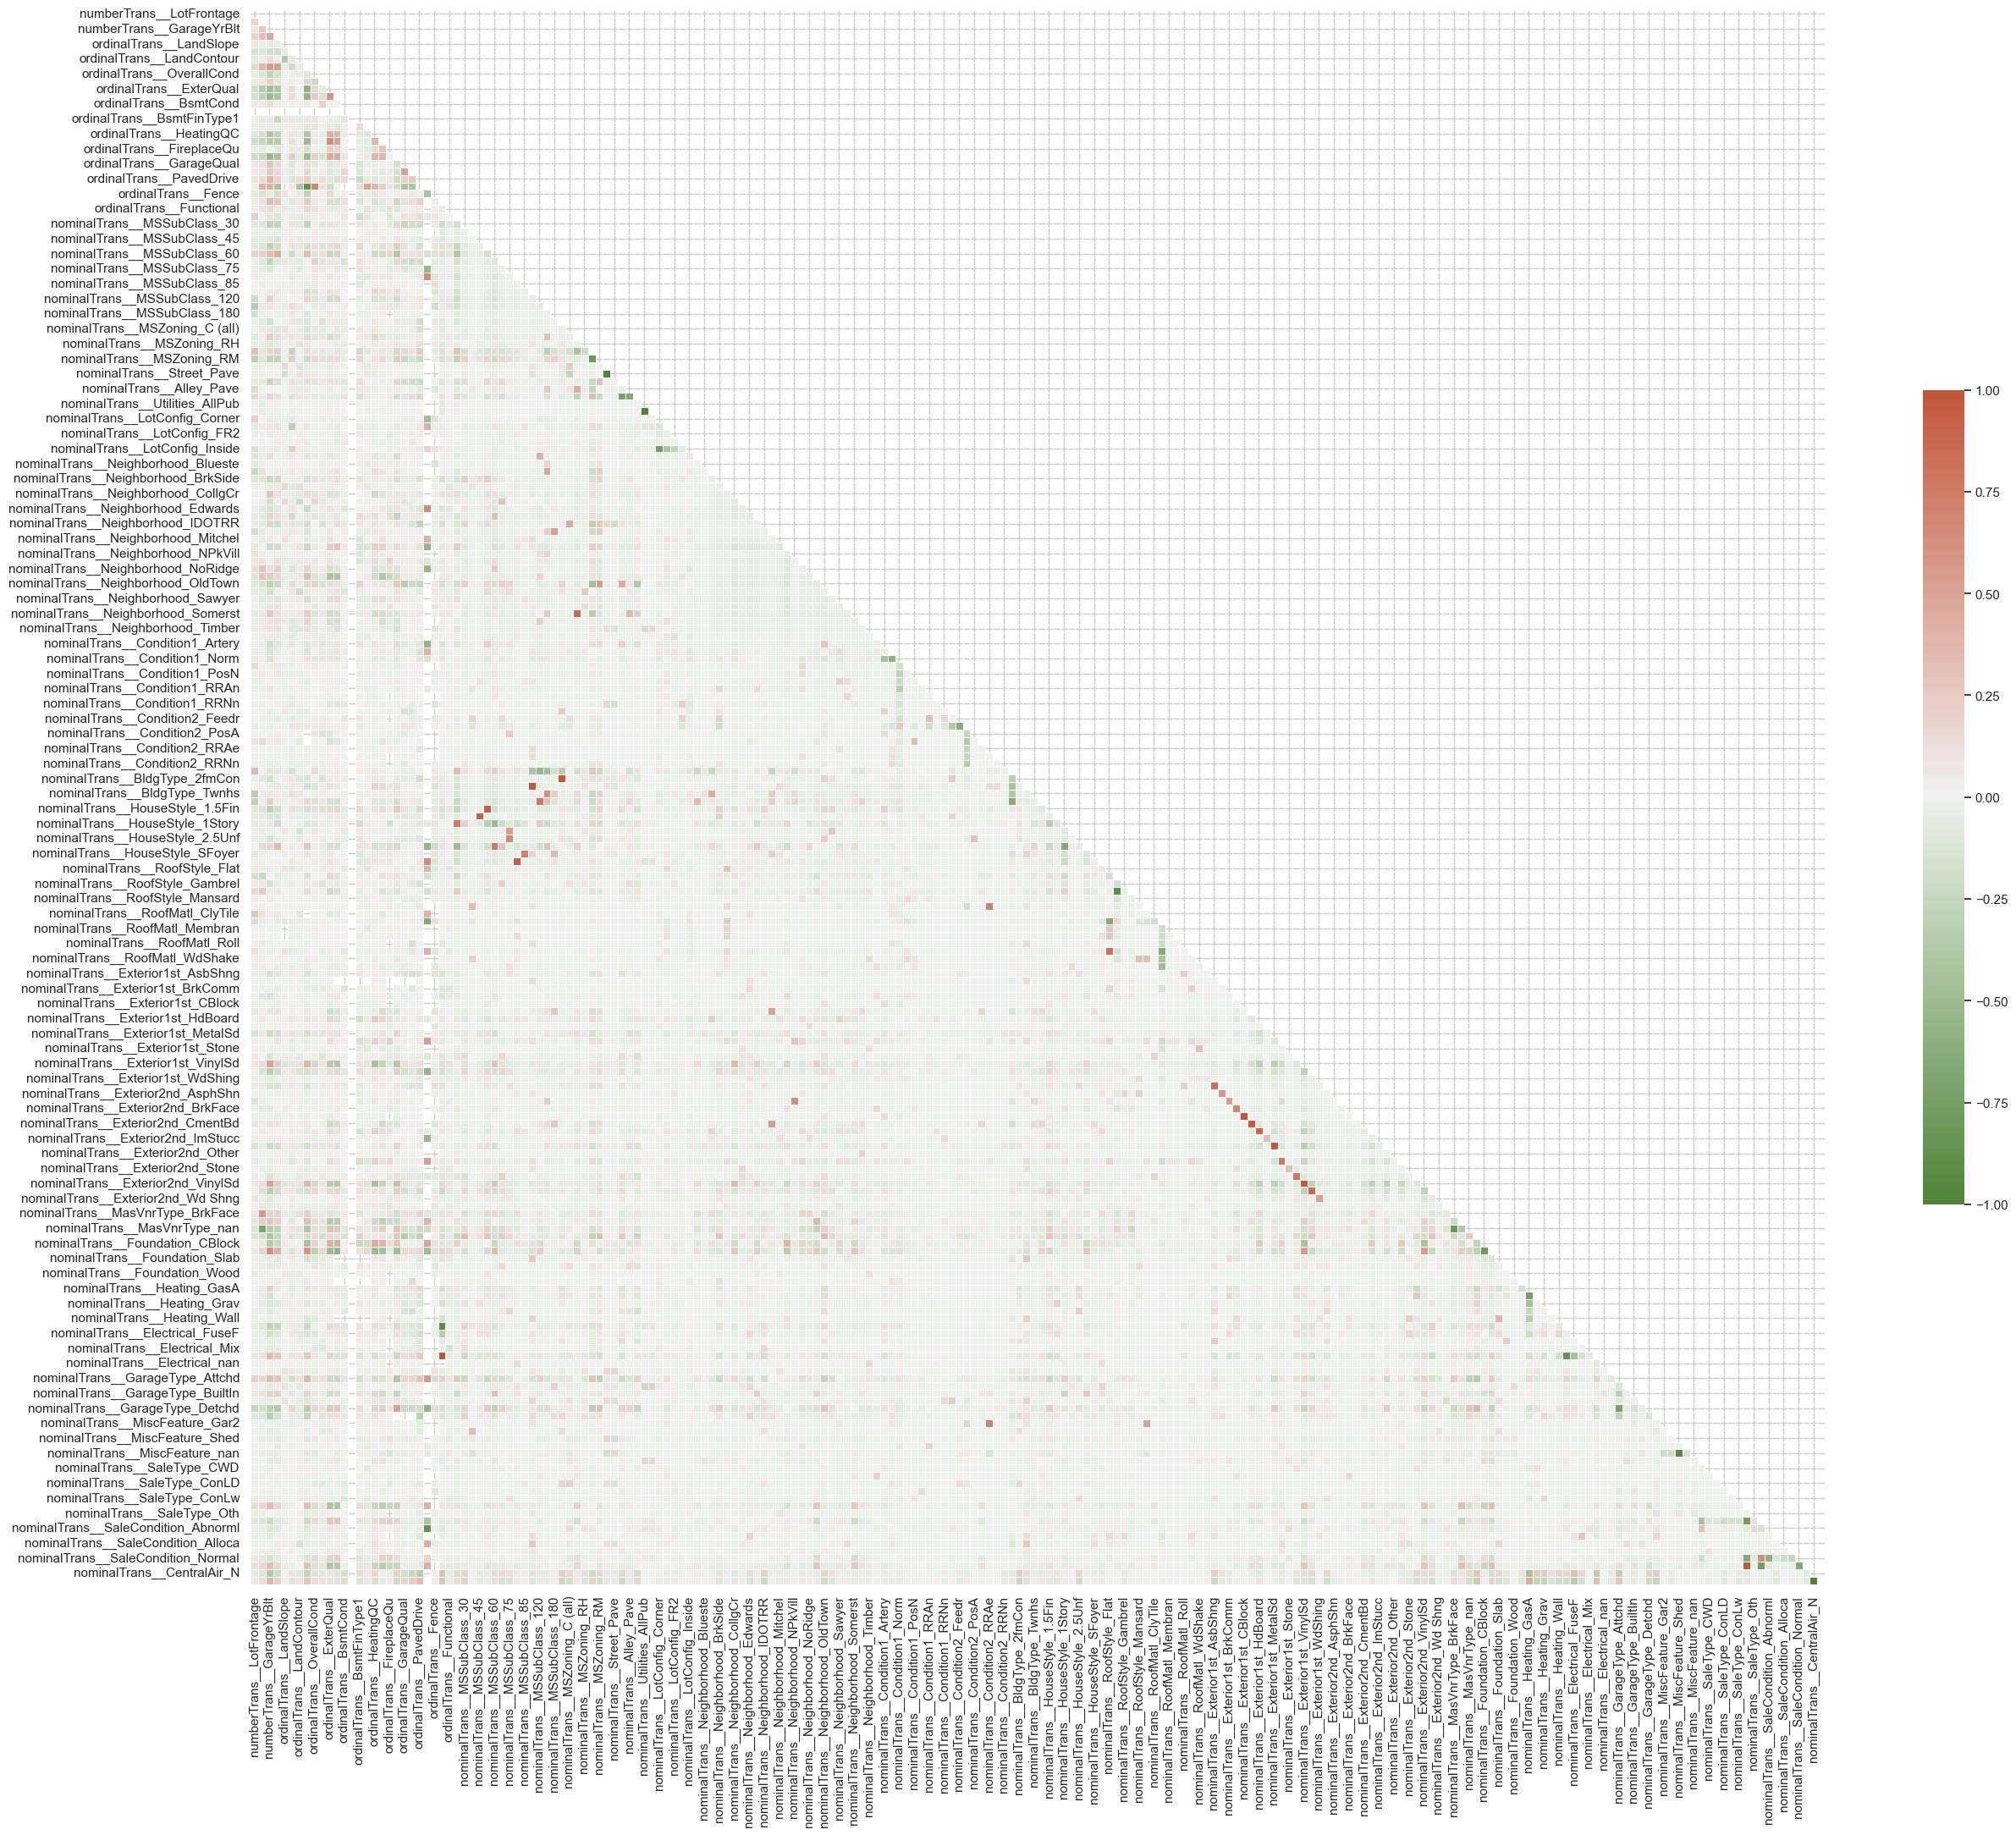

In [58]:
f, ax = plt.subplots(figsize=(30, 25))
mat = train_tr.corr('pearson')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(120, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0, annot = False,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [48]:
corrs = train_tr.corrwith(train_rind["SalePrice"])

In [59]:
corrs.sort_values(ascending=False, inplace=True)
print(corrs)

nominalTrans__Exterior1st_Stucco      0.089380
nominalTrans__Exterior2nd_Stucco      0.084588
nominalTrans__Alley_Grvl              0.054340
nominalTrans__Neighborhood_Mitchel    0.054153
nominalTrans__SaleCondition_Family    0.045124
                                        ...   
nominalTrans__MSZoning_C (all)       -0.047964
nominalTrans__Electrical_FuseA       -0.051255
nominalTrans__MSSubClass_20          -0.057596
ordinalTrans__PoolQC                 -0.062531
ordinalTrans__BsmtExposure                 NaN
Length: 210, dtype: float64


Text(0, 0.5, 'Pearson Correlation')

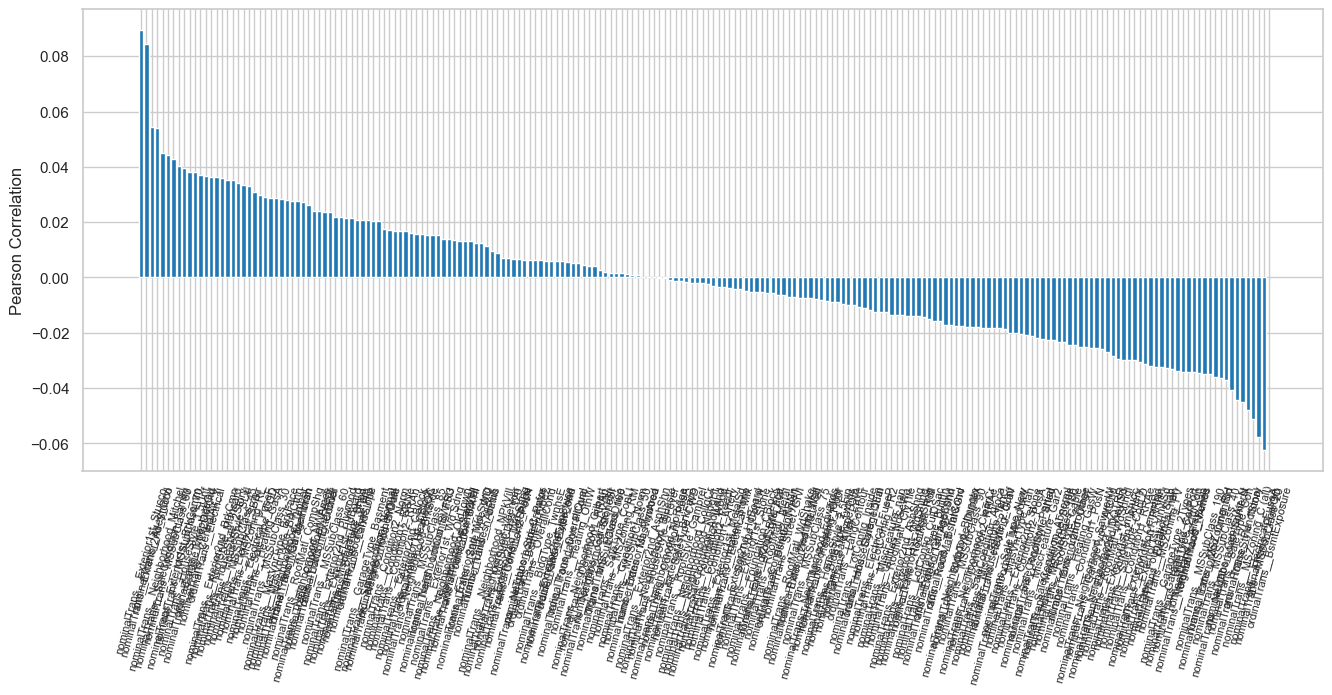

In [50]:
fig, ax = plt.subplots(1,1, figsize=(16,6))
ax.bar(corrs.index, corrs.values)
_=ax.set_xticklabels(ax.get_xticklabels(), rotation=75, fontsize=8)
ax.set_ylabel("Pearson Correlation")

In [53]:
corrs

nominalTrans__Exterior1st_Stucco      0.089380
nominalTrans__Exterior2nd_Stucco      0.084588
nominalTrans__Alley_Grvl              0.054340
nominalTrans__Neighborhood_Mitchel    0.054153
nominalTrans__SaleCondition_Family    0.045124
                                        ...   
nominalTrans__MSZoning_C (all)       -0.047964
nominalTrans__Electrical_FuseA       -0.051255
nominalTrans__MSSubClass_20          -0.057596
ordinalTrans__PoolQC                 -0.062531
ordinalTrans__BsmtExposure                 NaN
Length: 210, dtype: float64